In [1]:
def init_environment(forzar_drive=False):
  # 1) Montar Google Drive
  from google.colab import drive
  drive.mount('/content/drive', force_remount=forzar_drive)

  # 2) Rutas base
  from pathlib import Path
  BASE_DIR     = Path('/content/drive/MyDrive/structure')
  MODELS_DIR   = BASE_DIR / 'models'
  NOTEBOOKS_DIR= BASE_DIR / 'notebooks'
  CONFIGS_DIR  = BASE_DIR / 'configs'
  DATA_DIR     = BASE_DIR / 'datasets/processed'
  LOGS_DIR     = BASE_DIR / 'logs'

  for d in (MODELS_DIR, NOTEBOOKS_DIR, LOGS_DIR):
      d.mkdir(parents=True, exist_ok=True)

  # 3) Path y sys.path
  import sys
  sys.path.append(str(MODELS_DIR))
  sys.path.append(str(BASE_DIR))

Mounted at /content/drive
⬇️  Descargando «carlosandres069/snr8-12-taps2-phase-0-45» …
Dataset URL: https://www.kaggle.com/datasets/carlosandres069/snr8-12-taps2-phase-0-45


100%|██████████| 749M/749M [00:05<00:00, 147MB/s]



✅ Usando archivo HDF5: datasets/kaggle/snr8_12_taps2_phase0_45.hdf5
✔️ Modelo Keras inicializado

✔️ Experimento «exp_model1_b» cargado con éxito.


=== EXPERIMENTO ===
╒═══════════════╤═══════════════════════════════════════════════════════════════════╕
│ Campo         │ Valor                                                             │
╞═══════════════╪═══════════════════════════════════════════════════════════════════╡
│ Nombre        │ exp_model1_b                                                      │
├───────────────┼───────────────────────────────────────────────────────────────────┤
│ Descripción   │ Model1 con dos capas ocultas [128,64], dropout=0.3 y dataset HDF5 │
├───────────────┼───────────────────────────────────────────────────────────────────┤
│ Módulo modelo │ model1                                                            │
├───────────────┼───────────────────────────────────────────────────────────────────┤
│ Clase modelo  │ NN                                    

Model: "AMCModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ IQ_input            │ (None, 4096, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 4096, 64)  │        448 │ IQ_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 4096, 64)  │        704 │ IQ_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 4096, 64)  │        960 │ IQ_input[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 4096, 192) │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 4096, 192) │        768 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 1024, 192) │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1024, 128) │     73,856 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 128) │        512 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 1024, 128) │     49,280 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 1024, 128) │     24,704 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024, 128) │        512 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1024, 128) │          0 │ conv1d_5[0][0],   │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1024, 128) │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 256, 128)  │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 256, 256)  │     98,560 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256)  │      1,024 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 256, 256)  │    196,864 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 256, 256)  │     33,024 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 846,536 (3.23 MB)

 Trainable params: 844,616 (3.22 MB)

 Non-trainable params: 1,920 (7.50 KB)

Epoch 1/5
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.3452 - loss: 1.5548
Epoch 1: val_accuracy improved from -inf to 0.26277, saving model to /content/drive/MyDrive/structure/outputs/model1_b/checkpoints/epoch_01.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 59s 162ms/step - accuracy: 0.3454 - loss: 1.5540 - val_accuracy: 0.2628 - val_loss: 41423.7695
Epoch 2/5
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.4917 - loss: 1.1146
Epoch 2: val_accuracy improved from 0.26277 to 0.46225, saving model to /content/drive/MyDrive/structure/outputs/model1_b/checkpoints/epoch_02.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 45s 158ms/step - accuracy: 0.4917 - loss: 1.1146 - val_accuracy: 0.4622 - val_loss: 23458.2266
Epoch 3/5
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5052 - loss: 1.0829
Epoch 3: val_accuracy improved from 0.46225 to 0.48509, saving model to /content/drive/MyDrive/structure/outputs/model1_b/checkpoints/epoch_03.keras
287/287 ━━━━━━━━━━━━━━━━━━━━ 46s 161ms/step - a

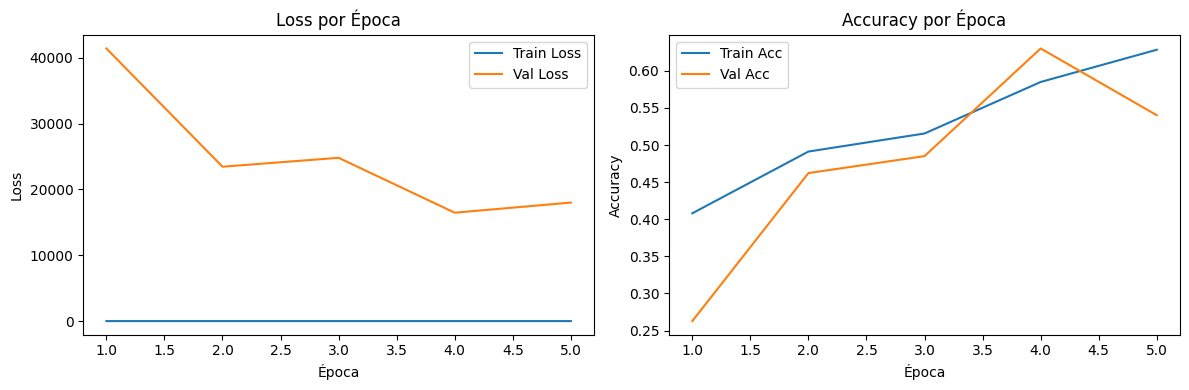

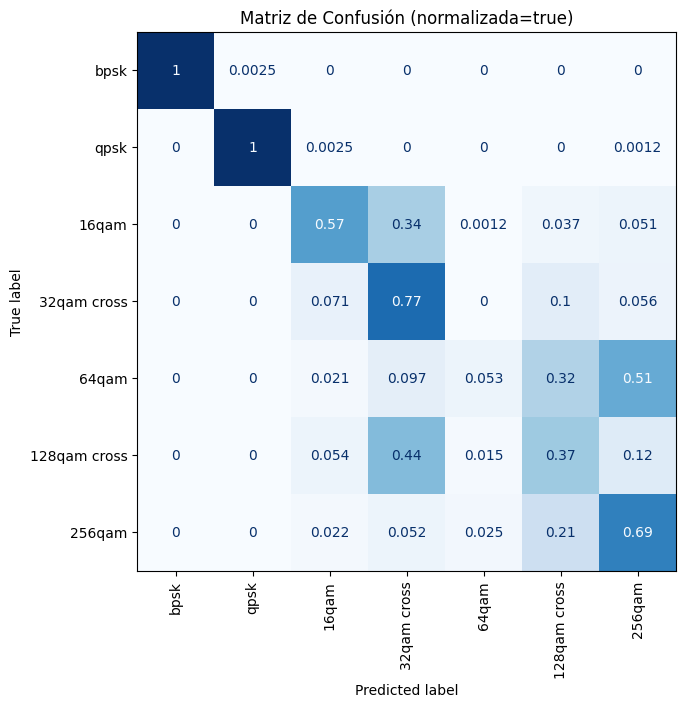

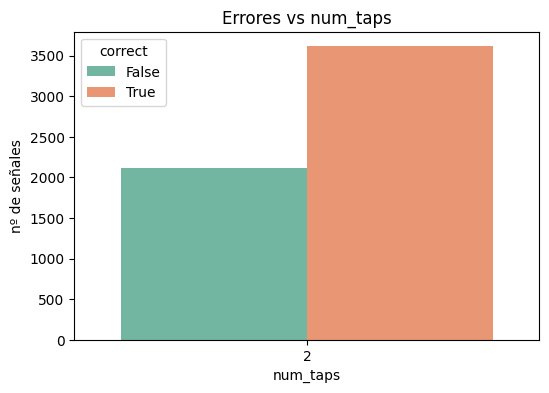

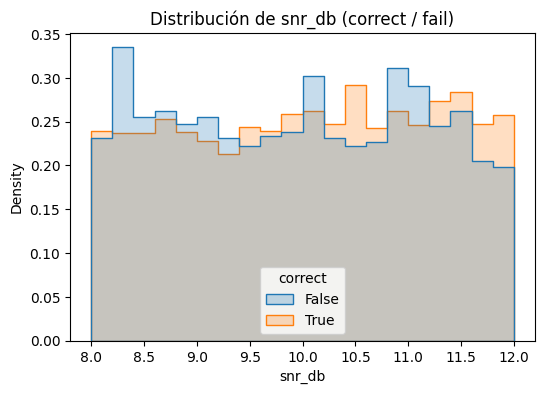

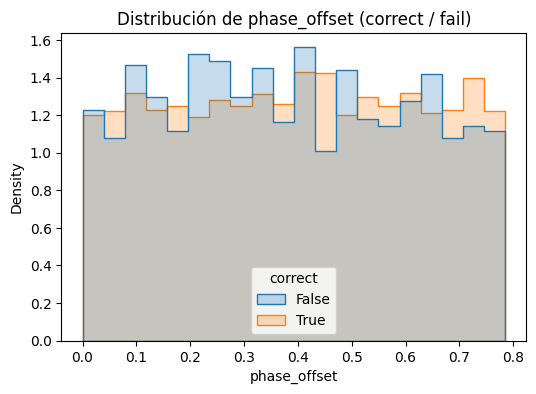

In [2]:
# =============================================================================
# 🚀 Notebook principal de experimentación con TensorFlow/Keras
# =============================================================================

# 1) Preparar el entorno
#    - Monta Google Drive
#    - Ajusta sys.path para encontrar tus módulos en models/ y utils/
init_environment(forzar_drive=True)

# 2) Definir experimento
#    El nombre debe coincidir con un archivo YAML en configs/experiments/
exp_name = "exp_model1_b"

# 3) Cargar configuración y datos
from utils.experiment.functions import load_experiment
cfg, NNClass, params, dataset, train_data, val_data = load_experiment(exp_name)


# 4) Instanciar el modelo
#    BaseTFModel se encarga de build_model(), compile() y callbacks
model = NNClass(cfg, **params)


# 5) Mostrar resumen de la configuración
from utils.misc.functions import print_exp_configuration
print(f"\n✔️ Experimento «{cfg['experiment']['name']}» cargado con éxito.\n")
print_exp_configuration(cfg)

# 6) Mostrar arquitectura del modelo
print("\n📋 Arquitectura del modelo:")
model.model.summary()

# 7) Entrenar (o retomar) hasta la época final
history = model.fit(train_data, val_data)

# 8) Evaluación final en validación
loss, acc = model.model.evaluate(val_data, verbose=2)
print(f"\n🔍 Resultados finales — Loss: {loss:.4f}, Accuracy: {acc:.4f}")

# 9) Análisis
from utils.analysis.analysis import ExperimentAnalyzer

analyzer = ExperimentAnalyzer(
    model.model,
    history,
    val_data,                                 # tf.data.Dataset con índices
    class_names=cfg["dataset"].get("class_names"),
    effects=dataset.get_effects("val")        # Structured array
)

# gráficos habituales
analyzer.plot_training_curves()
analyzer.confusion_matrix(normalize="true")

# nuevos diagnósticos
analyzer.effect_diagnostics("num_taps")
analyzer.effect_diagnostics("snr_db")
analyzer.effect_diagnostics("phase_offset")
analyzer.effect_diagnostics("roll_off")